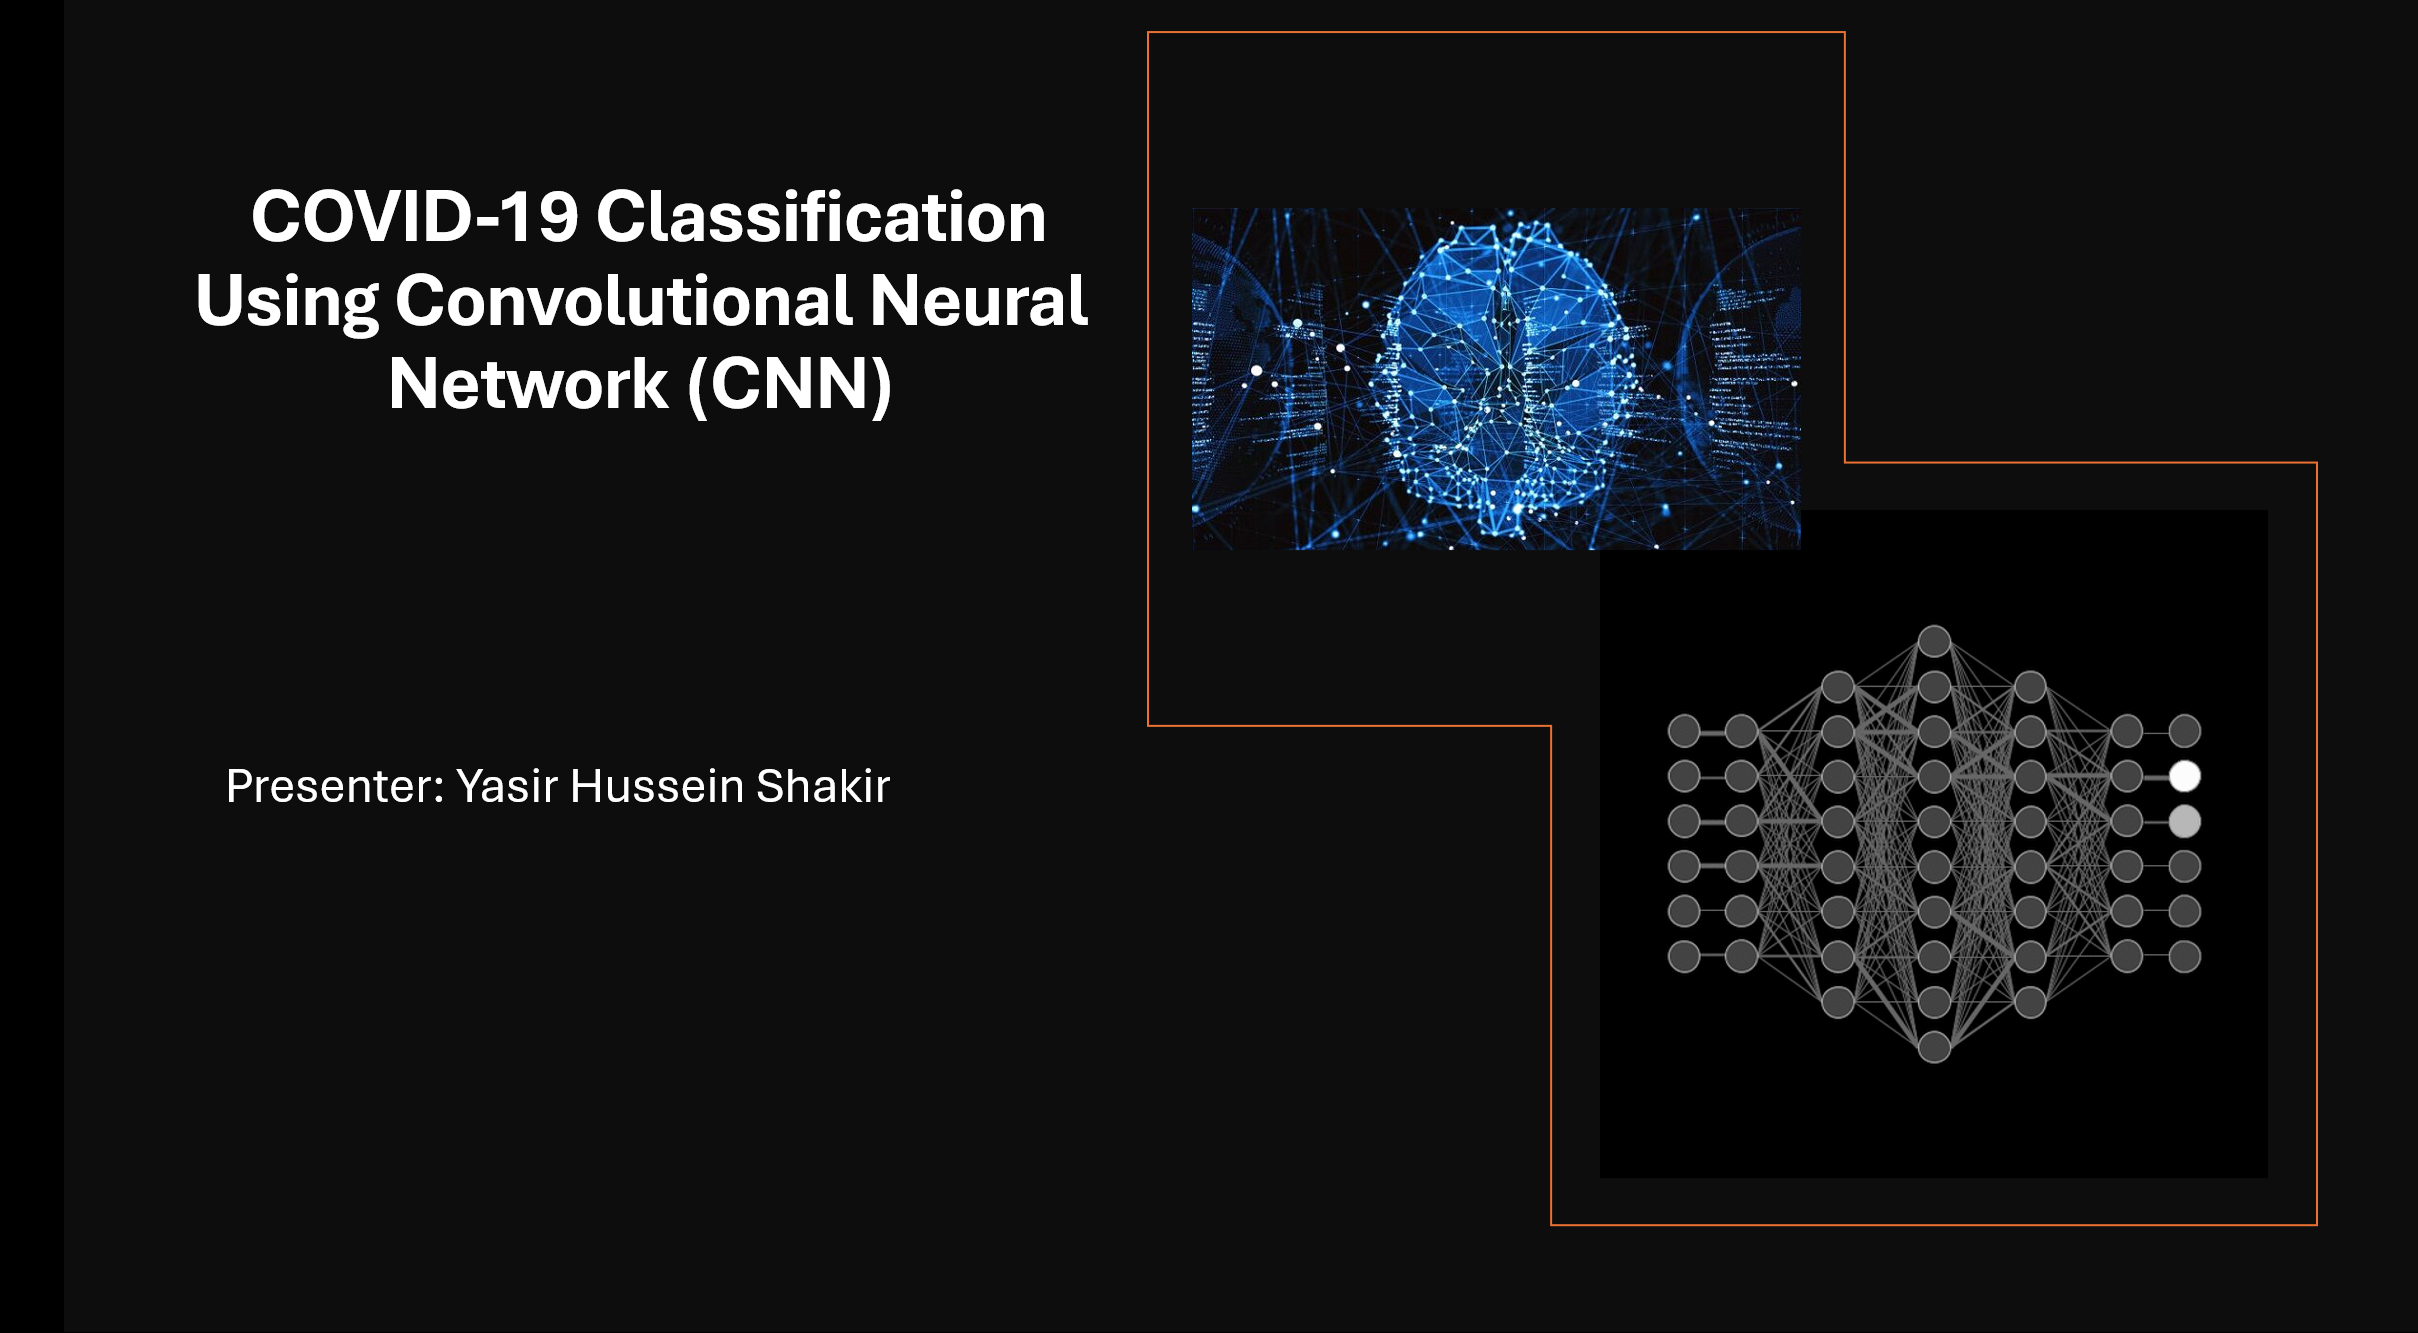

In [1]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Extract the images
!unzip /content/drive/MyDrive/Deep_Covid_19/Data.zip -d /content/data

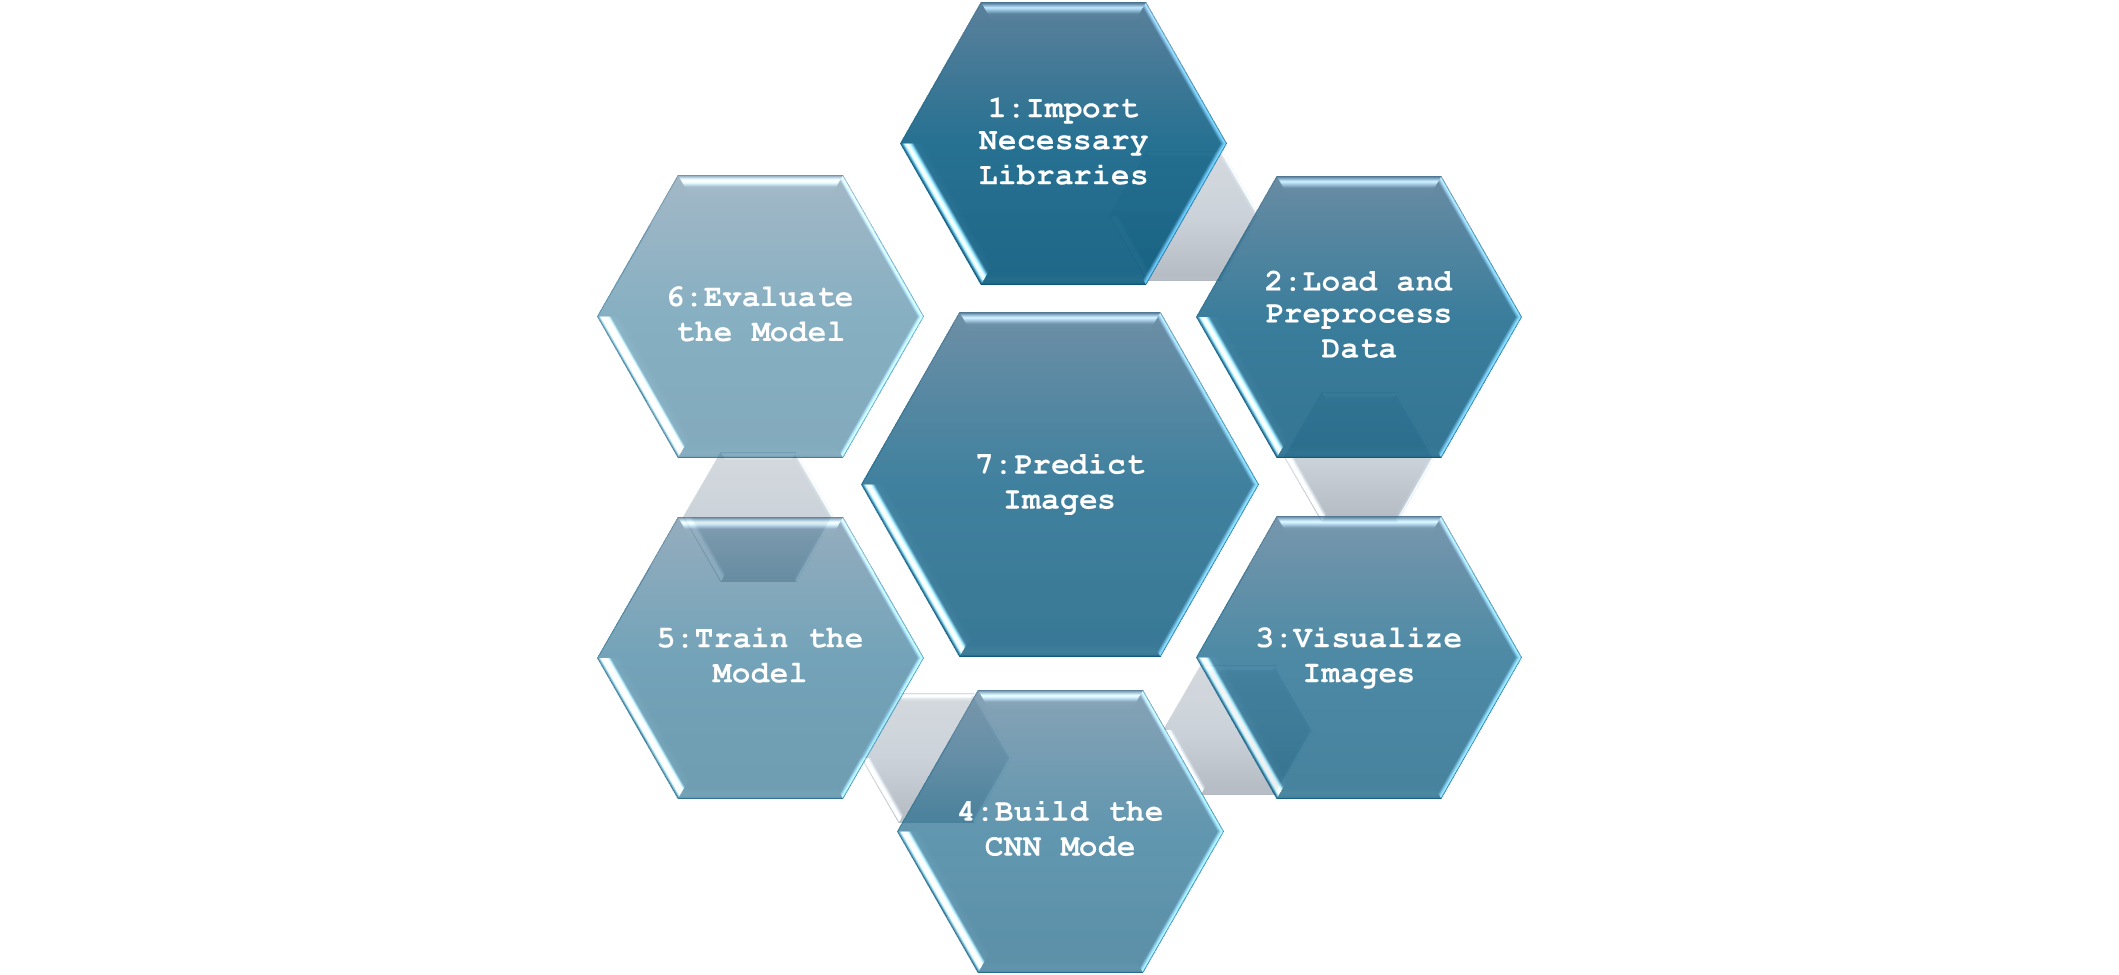

In [3]:
#Step 1: Import Necessary Libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(22)
tf.random.set_seed(22)

In [4]:
#Step 2: Load and Preprocess Data

# Paths to your data folders
data_dir = '/content/data/COVID_IEEE'
img_size = (128, 128)
batch_size = 32

In [ ]:
# Data rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Training and validation data generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

In [ ]:
#Step 3: Visualize 9 Images

def show_sample_images(generator, class_names, num_images=3):
    plt.figure(figsize=(10, 10))
    classes_shown = {class_name: 0 for class_name in class_names}
    i = 0

    while any([v < num_images for v in classes_shown.values()]):
        img_batch, label_batch = next(generator)
        for img, label in zip(img_batch, label_batch):
            class_name = class_names[np.argmax(label)]
            if classes_shown[class_name] < num_images:
                plt.subplot(3, 3, i + 1)
                plt.imshow(img)
                plt.title(class_name)
                plt.axis("off")
                i += 1
                classes_shown[class_name] += 1
            if i >= 9:
                break

# Show images from training generator
class_names = list(train_generator.class_indices.keys())
show_sample_images(train_generator, class_names)
plt.show()

In [7]:
#Step 4: Build the CNN Mode

# Build CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Add Dropout after flattening
    layers.Dropout(0.6),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),

    layers.Dense(3, activation='softmax')
])

'''
1-This layer applies 32 filters (feature detectors) with a
3x3 kernel size on the input images of shape 128x128 pixels with 3 color channels (RGB).
 The relu activation function introduces non-linearity to the model.

2- maxPooling2D((2, 2)): This reduces the spatial dimensions (height and width) by a factor of 2,
 retaining only the most important features and reducing computational complexity.

3-This block applies 64 filters, again with a 3x3 kernel,
 followed by a pooling operation to downsample the feature map.

4- This layer randomly sets 50% of the input units to zero during training.
Dropout helps prevent overfitting by reducing co-adaptation of neurons.
'''

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


'\n1-This layer applies 32 filters (feature detectors) with a \n3x3 kernel size on the input images of shape 128x128 pixels with 3 color channels (RGB).\n The relu activation function introduces non-linearity to the model.\n\n2- maxPooling2D((2, 2)): This reduces the spatial dimensions (height and width) by a factor of 2,\n retaining only the most important features and reducing computational complexity.\n\n3-This block applies 64 filters, again with a 3x3 kernel,\n followed by a pooling operation to downsample the feature map.\n\n4- This layer randomly sets 50% of the input units to zero during training. \nDropout helps prevent overfitting by reducing co-adaptation of neurons.\n'

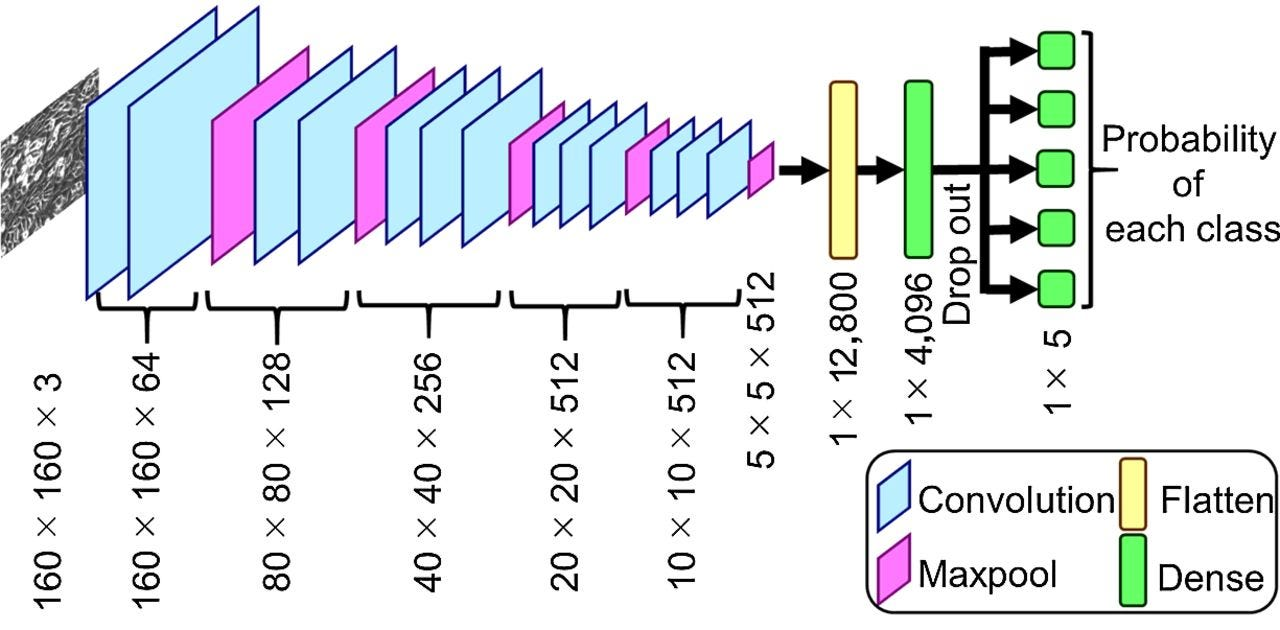

In [ ]:
# Print the model summary
model.summary()

In [9]:
# Custom Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

In [10]:
# Compile the model
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualize the Feature Extractor (Model)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#tep 5: Train the Model

history = model.fit(
    train_generator,
    epochs=12,
    validation_data=validation_generator
)

In [13]:
#Step 6: Evaluate the Model

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 701ms/step - accuracy: 0.8844 - loss: 0.2670
Validation Loss: 0.2668, Validation Accuracy: 0.8904


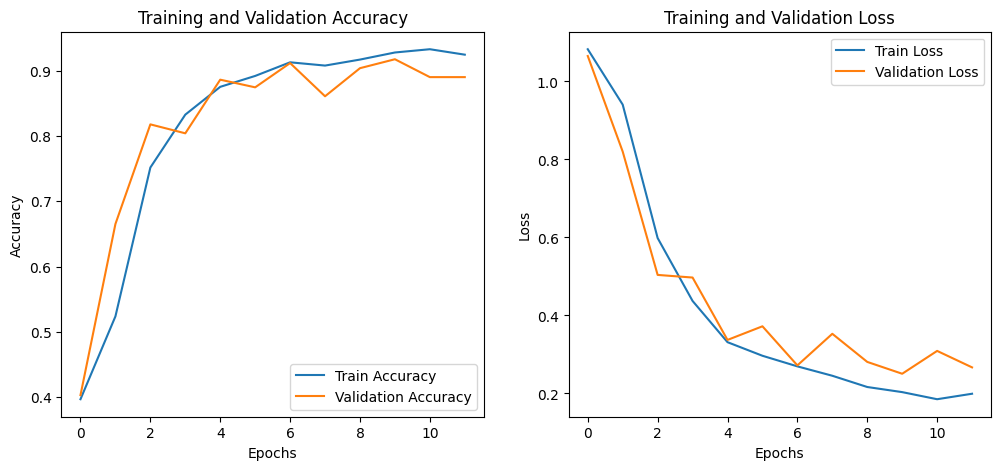

In [14]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


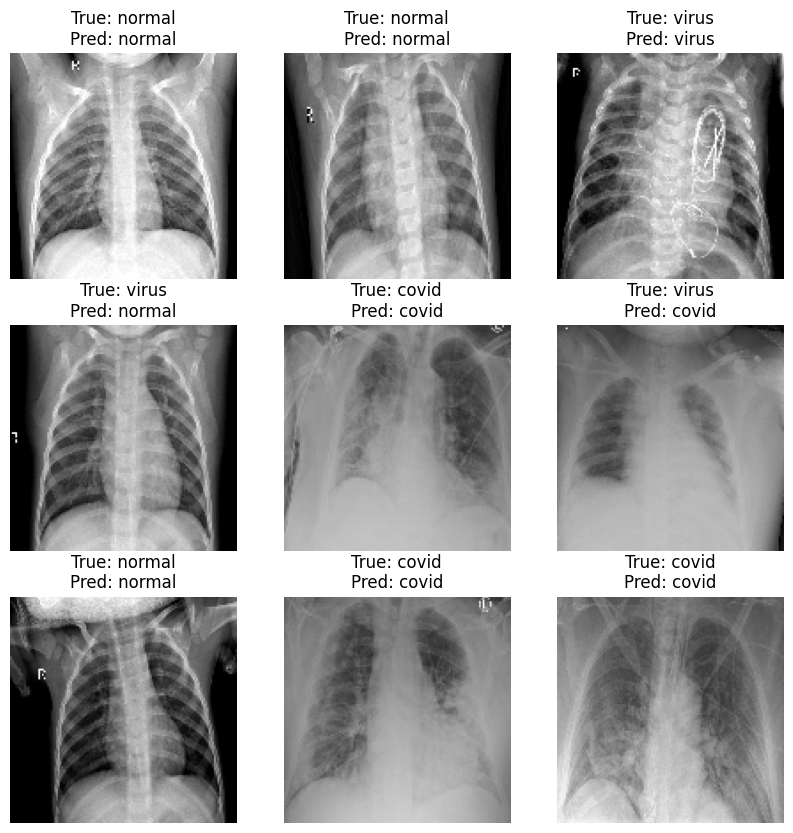

In [17]:
#Step 7: Predict  Images

def show_predictions(generator, model, class_names, num_images=3):
    plt.figure(figsize=(10, 10))
    classes_shown = {class_name: 0 for class_name in class_names}
    i = 0

    while any([v < num_images for v in classes_shown.values()]):
        img_batch, label_batch = next(generator)
        preds = model.predict(img_batch)
        for img, label, pred in zip(img_batch, label_batch, preds):
            class_name = class_names[np.argmax(label)]
            predicted_class = class_names[np.argmax(pred)]
            if classes_shown[class_name] < num_images:
                plt.subplot(3, 3, i + 1)
                plt.imshow(img)
                plt.title(f'True: {class_name}\nPred: {predicted_class}')
                plt.axis("off")
                i += 1
                classes_shown[class_name] += 1
            if i >= 9:
                break

# Show predictions on test images
show_predictions(validation_generator, model, class_names)
plt.show()

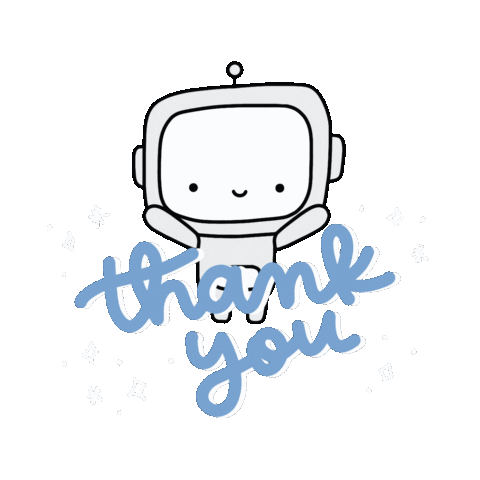